In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython import display

## Intro

<!-- PELICAN_BEGIN_SUMMARY -->

Came across [a fun little problem on the subreddit /r/theydidthemath](https://www.reddit.com/r/theydidthemath/comments/dgas2b/request_how_accurate_is_this_chart/) that asked about the accuracy of a joke pie chart.

The top post by the time I showed up took took a quick crack at checking the pixel diameter and-- per the subreddit name-- "doing the math."

But having done something very similar to this [in my last post](https://napsterinblue.github.io/blog/2019/07/22/making-images-paletteable/), I figured this is a good an excuse as any to recycle some old code and write for the first time in a couple months.

Using a similar idea as the last post, we'll group all of the colors of the image into like colors. Then we'll simply divide the blue, `my birthday`, by the area of the circle.

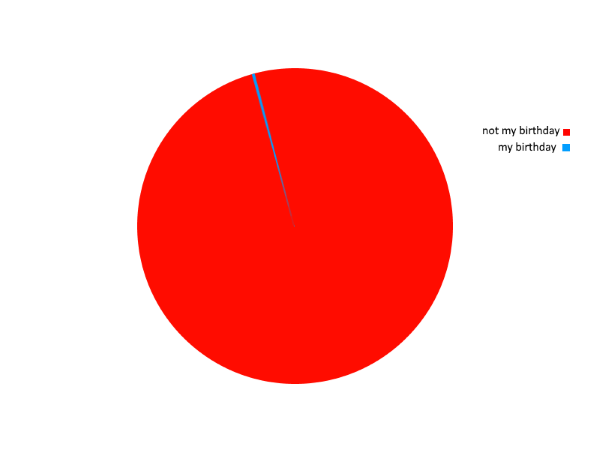

In [3]:
display.Image('orig.png')

<!-- PELICAN_END_SUMMARY -->

### Image to Data

We'll start by importing the vanilla Image library in Python.

In [4]:
from PIL import Image, ImageDraw

I went ahead and downloaded the image from the post and trimmed it down to just include the circle.

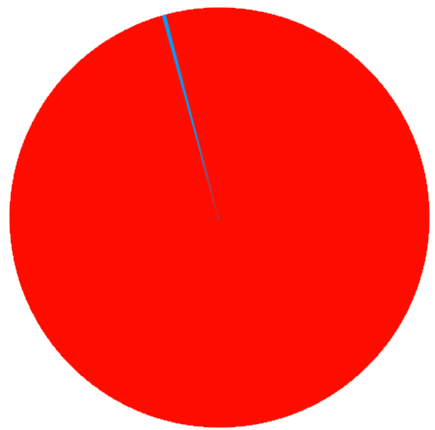

In [5]:
im = Image.open('circle.png')
im

And we'll stuff that into `numpy` to get its per-pixel, numerical representation

In [6]:
arr = np.array(im)
arr.shape

(430, 435, 3)

### Bit of Color Finagling

The legend in our original image was two-tone (red/blue). But we've got a bit of a hiccup when we zoom in on locations where two colors meet. Our eyes don't notice it looking at the regular-sized image, but whatever produced this graphic did so with a bit of color fuzziness.

For instance, there are a ton of different purple-y shades at the boundary where blue meets red.

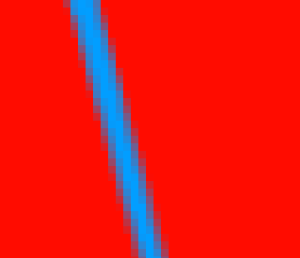

In [7]:
Image.open('sliver_zoom.PNG')

And pinks where the red meets the white.

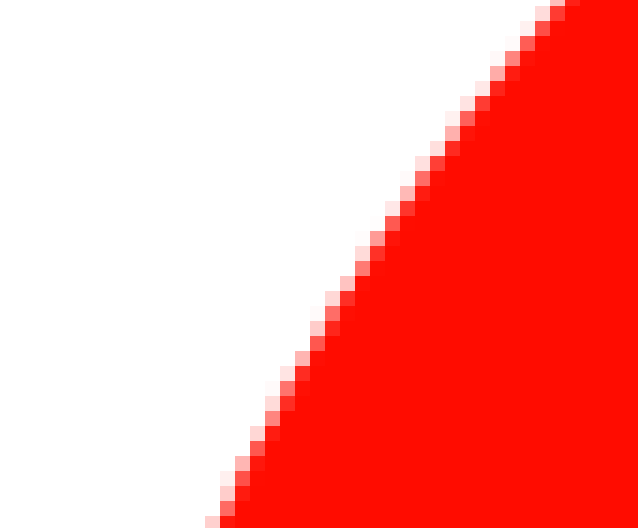

In [8]:
Image.open('edge_zoom.PNG')

## Distilling

So as mentioned up top, we'll employ [the same cheeky KMeans application as before](https://napsterinblue.github.io/blog/2019/07/22/making-images-paletteable/) to find clusters of "like colors."

By my count, we should expect to see a:

- Red group
- Blue group
- Pink group
- White group
- Purple group

So let's load up a blank `KMeans` model that anticipates finding 5 color groupings

In [9]:
from sklearn.cluster import KMeans

model = KMeans(5)

And run it on our data

In [10]:
arr = arr.reshape(-1, 3)
model.fit(arr);

We can then inspect what picked colors are

In [11]:
np.set_printoptions(precision=3, suppress=True)

print(model.cluster_centers_[:, :3])

[[254.961  12.15    0.175]
 [254.998 254.85  254.844]
 [ 26.367 143.491 230.136]
 [254.88  157.388 152.969]
 [149.223  72.241 106.11 ]]


But this isn't terribly helpful, so we'll borrow [some helper code we stashed in this notebook](https://napsterinblue.github.io/notes/python/images/rectangles/).

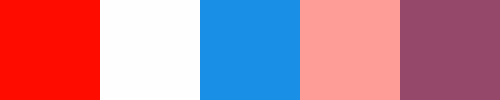

In [12]:
from helper import draw_rectangle

draw_rectangle(model.cluster_centers_)

Much better.

Then we can identify each of our points by which "Mean Color" they're closest to-- the index on the left corresponds to the order of the colors above.

In [13]:
import pandas as pd

res = pd.Series(model.predict(arr)).value_counts()
res.sort_index()

0    137612
1     47820
2       324
3      1012
4       282
dtype: int64

So if we wanted to describe "blue divided by everything not white", we'd have

In [18]:
image = res[2] / (res.sum() - res[1])

Which works out to be about a quater of a percent of the area of the circle

In [19]:
image * 100

0.23270846800258566

Going back to the original question, the author wanted to know how this stacked up against the actual ratio of birthdays to not birthdays in a year.

In [20]:
birthday = 1 / 365
birthday * 100

0.273972602739726

Not bad, yeah? The result that you get when running `KMeans` is pretty random and dependent on how your machine happened to kick off the algorithm.

Had a few runs that were nearly identical. A good number that weren't. All told, though, I'd say that this image is pretty accurate.

In [21]:
(birthday - image) / birthday

0.1506140917905624

Though someone more patient than me might consider averaging the "pct blue in the circle" over many, many images to say for certain. But I think I've rabbit-holed on this plenty long enough already :)

Cheers,
-Nick

-----------

I hope reading my solution was at least half as amusing as it was coming up with.

As always, [link to my code can be found here](https://github.com/NapsterInBlue/circle). Feel free to [badger me on the Internet](https://twitter.com/home) if anything looks awry!